# 1. Exploration et Prétraitement des Données

In [3]:
# 📌 1️⃣ IMPORTATION DES LIBRAIRIES 📌 #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

# Éviter les avertissements inutiles
import warnings
warnings.filterwarnings('ignore')

# Paramètres d'affichage des DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 📌 2️⃣ CHARGEMENT DES FICHIERS 📌 #
print("📥 Chargement des fichiers CSV...")

# Chargement des données principales
general_data = pd.read_csv("csv/general_data.csv")
manager_survey_data = pd.read_csv("csv/manager_survey_data.csv")
employee_survey_data = pd.read_csv("csv/employee_survey_data.csv")

# Chargement des fichiers horaires
in_time = pd.read_csv("csv/in_time.csv")
out_time = pd.read_csv("csv/out_time.csv")

# Vérification des dimensions
print(f"📊 Taille de general_data: {general_data.shape}")
print(f"📊 Taille de manager_survey_data: {manager_survey_data.shape}")
print(f"📊 Taille de employee_survey_data: {employee_survey_data.shape}")
print(f"📊 Taille de in_time: {in_time.shape}")
print(f"📊 Taille de out_time: {out_time.shape}")

# 📌 3️⃣ RENOMMAGE ET VÉRIFICATION DES IDS 📌 #
# Renommer la colonne "Unnamed: 0" en "EmployeeID" pour assurer la correspondance
in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

# Vérification des colonnes après renommage
print("\n✅ Colonnes des fichiers horaires après renommage :")
print("in_time:", in_time.columns[:5], "...")
print("out_time:", out_time.columns[:5], "...")

# 📌 4️⃣ FUSION DES FICHIERS SUR "EmployeeID" 📌 #
print("\n🔄 Fusion des fichiers sur EmployeeID...")

df_merged = general_data.merge(manager_survey_data, on="EmployeeID", how="left")
df_merged = df_merged.merge(employee_survey_data, on="EmployeeID", how="left")

print(f"📊 Taille après fusion : {df_merged.shape}")

# 📌 5️⃣ NETTOYAGE DES DONNÉES 📌 #

# Remplacer "NA" textuel par NaN
df_merged.replace("NA", np.nan, inplace=True)

# Vérifier les valeurs manquantes
print("\n🔍 Valeurs manquantes par colonne :")
print(df_merged.isnull().sum().sort_values(ascending=False).head(10))

# Imputation des valeurs manquantes
for col in df_merged.select_dtypes(include=[np.number]).columns:
    df_merged[col].fillna(df_merged[col].median(), inplace=True)

for col in df_merged.select_dtypes(exclude=[np.number]).columns:
    df_merged[col].fillna(df_merged[col].mode()[0], inplace=True)

print("\n✅ Valeurs manquantes corrigées.")

# 📌 6️⃣ SUPPRESSION DE COLONNES INUTILES 📌 #
cols_to_drop = ['Over18', 'EmployeeCount', 'StandardHours']
df_merged.drop(columns=[c for c in cols_to_drop if c in df_merged.columns], inplace=True)

print("\n🗑️ Colonnes supprimées :", cols_to_drop)

# 📌 7️⃣ ENCODAGE DES VARIABLES CATÉGORIELLES 📌 #
encoder = LabelEncoder()

# Identifier les colonnes catégorielles
cat_cols = df_merged.select_dtypes(include=['object']).columns

# Encodage des variables catégorielles
for col in cat_cols:
    if col != "Attrition":  # La cible sera encodée séparément
        df_merged[col] = encoder.fit_transform(df_merged[col])

# Encodage de la cible (Attrition : "Yes"/"No" → 1/0)
if df_merged["Attrition"].dtype == 'object':
    df_merged["Attrition"] = df_merged["Attrition"].map({"Yes": 1, "No": 0})

print("\n✅ Encodage terminé.")

# 📌 8️⃣ FEATURE ENGINEERING : CALCUL DES HEURES MOYENNES 📌 #

def calculate_hours(in_time_row, out_time_row):
    """
    Calculer la durée moyenne journalière en heures pour un employé donné.
    """
    durations = []
    for date_col in in_time_row.index:
        if date_col == "EmployeeID":
            continue
        time_in = in_time_row[date_col]
        time_out = out_time_row[date_col]

        if pd.isna(time_in) or pd.isna(time_out):
            continue

        try:
            t_in = pd.to_datetime(time_in, errors='coerce')
            t_out = pd.to_datetime(time_out, errors='coerce')

            if pd.notna(t_in) and pd.notna(t_out):
                durations.append((t_out - t_in).total_seconds() / 3600.0)
        except:
            continue

    return np.mean(durations) if durations else np.nan

# Fusion des horaires
in_out_merged = pd.merge(in_time, out_time, on="EmployeeID", suffixes=("_in", "_out"))

# Calcul des heures moyennes
mean_hours_list = []
ids = []

for idx, row in in_out_merged.iterrows():
    emp_id = row["EmployeeID"]
    
    row_in = row.drop(labels=["EmployeeID"]).filter(like="_in")
    row_out = row.drop(labels=["EmployeeID"]).filter(like="_out")

    row_in.index = [col.replace("_in", "") for col in row_in.index]
    row_out.index = [col.replace("_out", "") for col in row_out.index]

    mean_hours = calculate_hours(row_in, row_out)
    
    ids.append(emp_id)
    mean_hours_list.append(mean_hours)

# Création du DataFrame avec EmployeeID et la moyenne des heures
df_hours = pd.DataFrame({
    "EmployeeID": ids,
    "MeanWorkingHours": mean_hours_list
})

# Fusion avec le dataset principal
df_merged = pd.merge(df_merged, df_hours, on="EmployeeID", how="left")

print("\n📊 Taille de df_merged après ajout de MeanWorkingHours :", df_merged.shape)
display(df_merged.head())

# 📌 9️⃣ STANDARDISATION DES VARIABLES NUMÉRIQUES 📌 #
num_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("Attrition")  # On ne standardise pas la cible

scaler = StandardScaler()
df_merged[num_cols] = scaler.fit_transform(df_merged[num_cols])

print("\n✅ Standardisation des variables numériques effectuée.")

# ✅ ÉTAPE TERMINÉE ✅ #
print("\n🎯 Exploration et prétraitement des données terminés avec succès ! 🚀")


📥 Chargement des fichiers CSV...
📊 Taille de general_data: (4410, 24)
📊 Taille de manager_survey_data: (4410, 3)
📊 Taille de employee_survey_data: (4410, 4)
📊 Taille de in_time: (4410, 262)
📊 Taille de out_time: (4410, 262)

✅ Colonnes des fichiers horaires après renommage :
in_time: Index(['EmployeeID', '2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06'], dtype='object') ...
out_time: Index(['EmployeeID', '2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06'], dtype='object') ...

🔄 Fusion des fichiers sur EmployeeID...
📊 Taille après fusion : (4410, 29)

🔍 Valeurs manquantes par colonne :
WorkLifeBalance            38
EnvironmentSatisfaction    25
JobSatisfaction            20
NumCompaniesWorked         19
TotalWorkingYears           9
Education                   0
EducationField              0
EmployeeCount               0
Age                         0
Attrition                   0
dtype: int64

✅ Valeurs manquantes corrigées.

🗑️ Colonnes supprimées : ['Over18', 'EmployeeCount

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MeanWorkingHours
0,51,0,2,2,6,2,1,1,0,1,0,1,131160,1.0,11,0,1.0,6,1,0,0,3,3,3.0,4.0,2.0,7.373651
1,31,1,1,1,10,1,1,2,0,1,6,2,41890,0.0,23,1,6.0,3,5,1,4,2,4,3.0,2.0,4.0,7.718969
2,32,0,1,1,17,4,4,3,1,4,7,1,193280,1.0,15,3,5.0,2,5,0,3,3,3,2.0,2.0,1.0,7.013240
3,38,0,0,1,2,5,1,4,1,3,1,1,83210,3.0,11,3,13.0,5,8,7,5,2,3,4.0,4.0,3.0,7.193678
4,32,0,2,1,10,1,3,5,1,1,7,2,23420,4.0,12,2,9.0,2,6,0,4,3,3,4.0,1.0,3.0,8.006175



✅ Standardisation des variables numériques effectuée.

🎯 Exploration et prétraitement des données terminés avec succès ! 🚀


# 2. Analyse Exploratoire (EDA)

📊 Taille du dataset après prétraitement : (4410, 27)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MeanWorkingHours
0,1.541369,0,0.590048,1.401512,-0.393938,-0.891688,-0.937414,-1.731658,-1.224745,-0.961486,-1.811675,-0.133282,1.405136,-0.678464,-1.150554,-0.932014,-1.322079,2.483396,-0.981014,-0.679146,-1.155935,0.379672,-0.426230,0.252200,1.156302,-1.085336,-0.244123
1,-0.648668,1,-0.913194,-0.493817,0.099639,-1.868426,-0.937414,-1.730873,-1.224745,-0.961486,0.626374,1.236820,-0.491661,-1.079486,2.129306,0.241988,-0.678877,0.155707,-0.327893,-0.368715,-0.034520,-1.026167,2.346151,0.252200,-0.663899,1.757749,0.013564
2,-0.539166,0,-0.913194,-0.493817,0.963398,1.061787,1.316673,-1.730087,0.816497,1.749610,1.032716,-0.133282,2.725053,-0.678464,-0.057267,2.589994,-0.807517,-0.620189,-0.327893,-0.679146,-0.314873,0.379672,-0.426230,-0.665460,-0.663899,-2.506879,-0.513073
3,0.117845,0,-2.416437,-0.493817,-0.887515,2.038524,-0.937414,-1.729302,0.816497,0.845911,-1.405334,-0.133282,0.386301,0.123580,-1.150554,2.589994,0.221606,1.707500,0.161947,1.493867,0.245834,-1.026167,-0.426230,1.169861,1.156302,0.336206,-0.378424
4,-0.539166,0,0.590048,-0.493817,0.099639,-1.868426,0.565311,-1.728516,0.816497,-0.961486,1.032716,1.236820,-0.884109,0.524602,-0.877232,1.415991,-0.292956,-0.620189,-0.164613,-0.679146,-0.034520,0.379672,-0.426230,1.169861,-1.573999,0.336206,0.227886


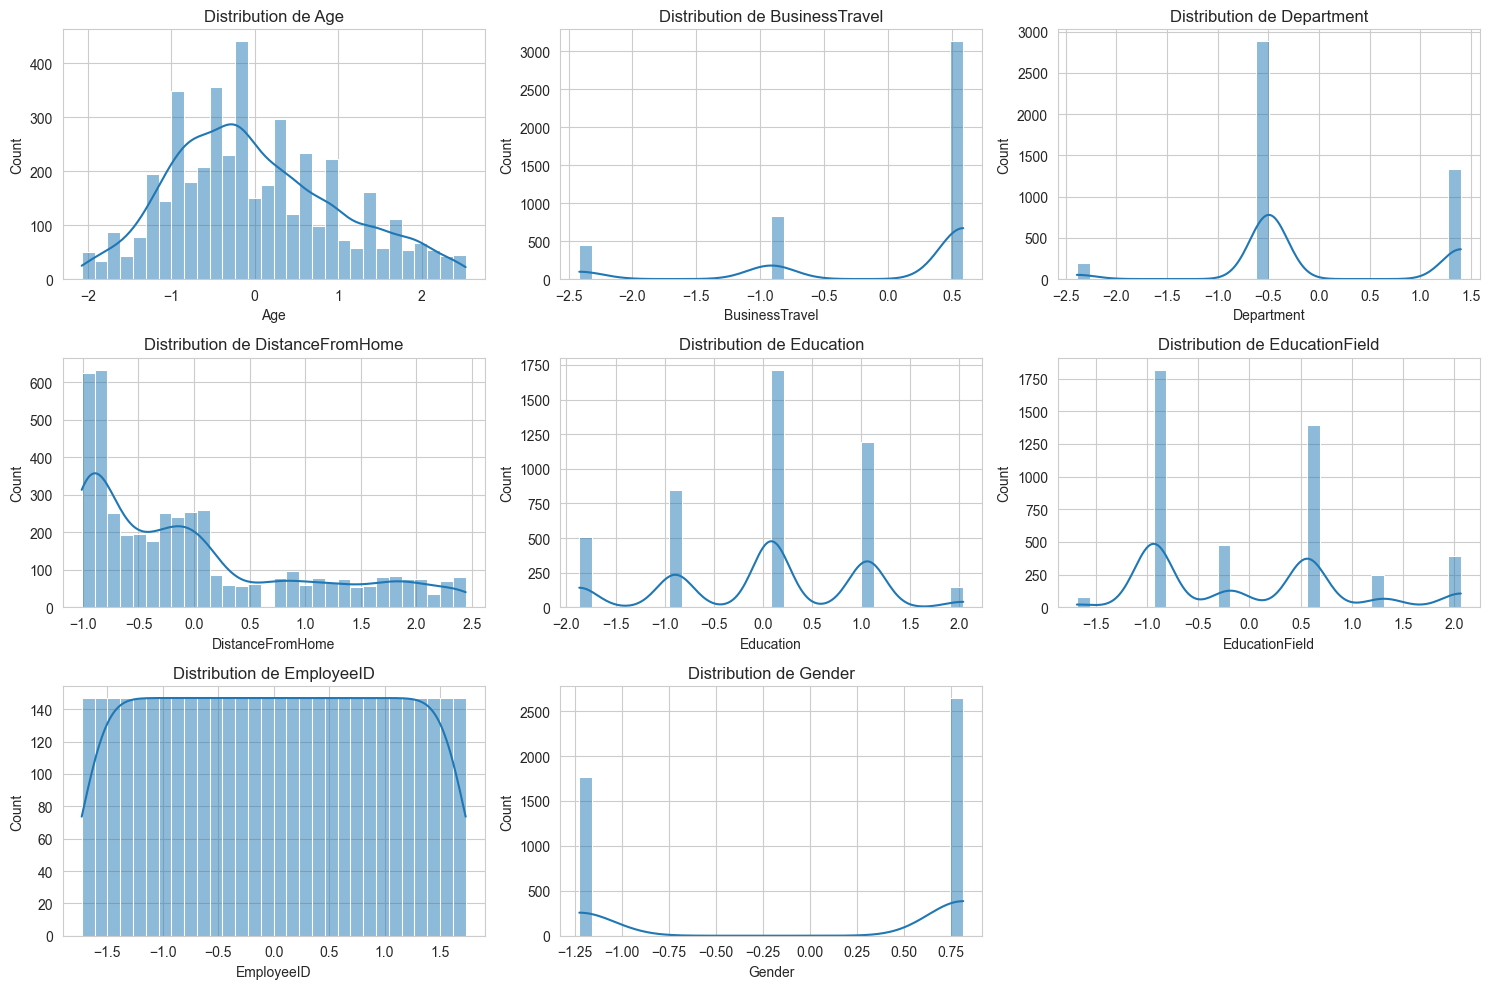

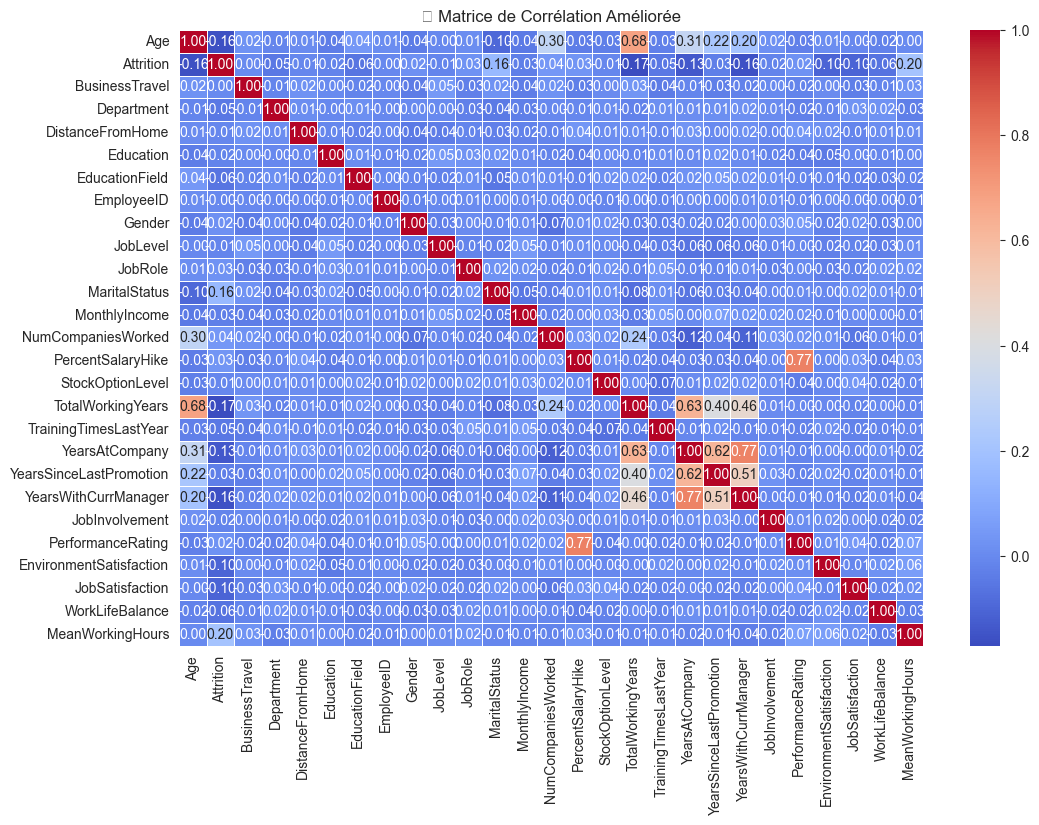

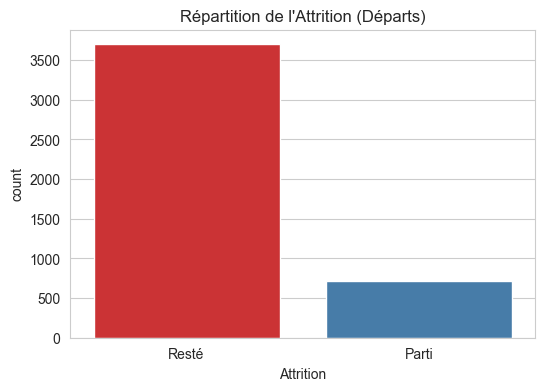

📊 Taux d'attrition global : 16.12%


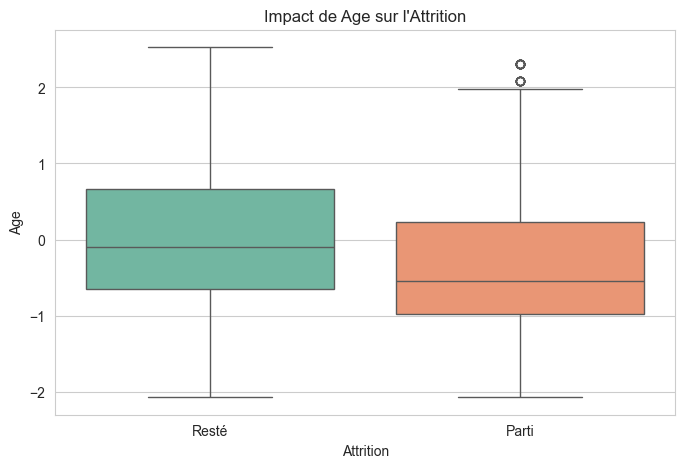

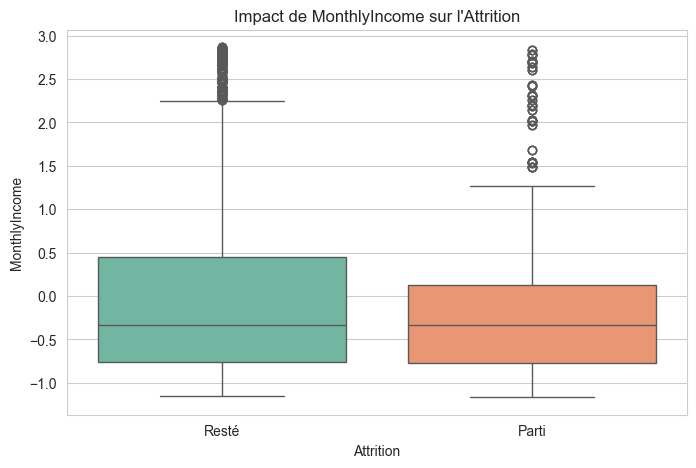

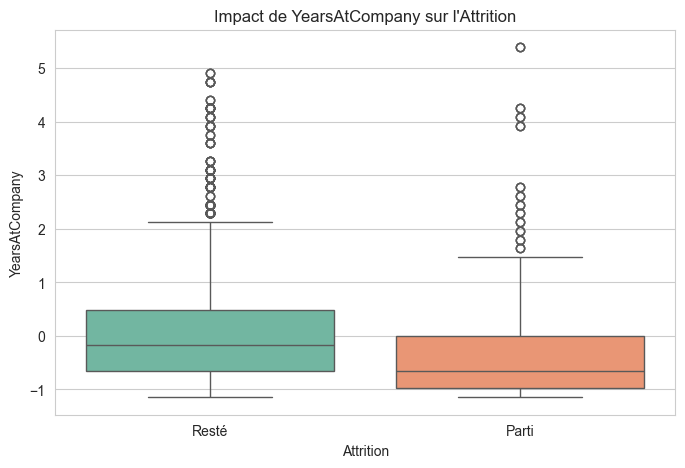

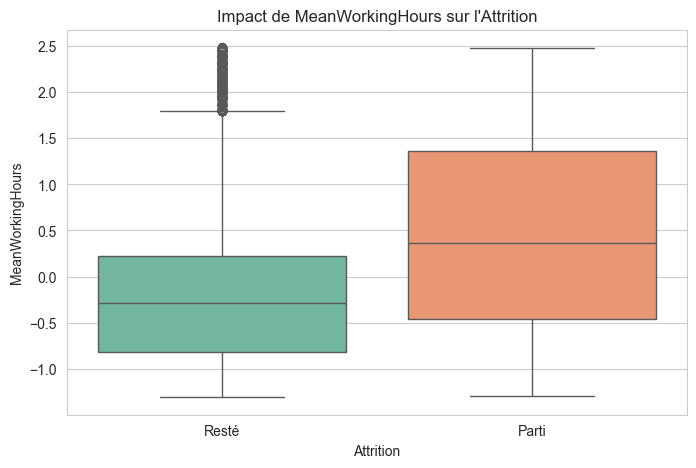

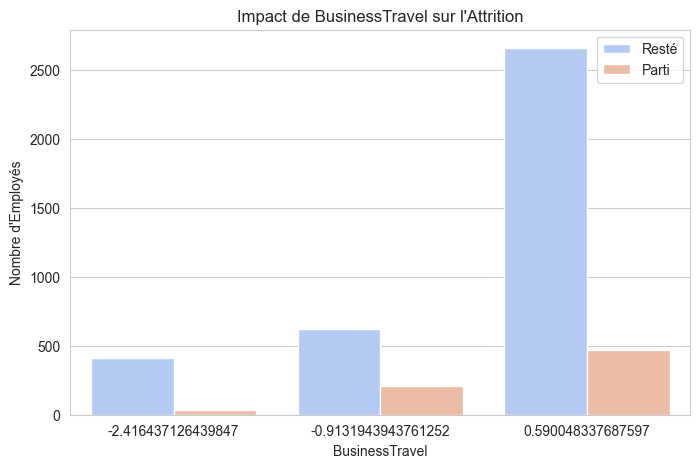

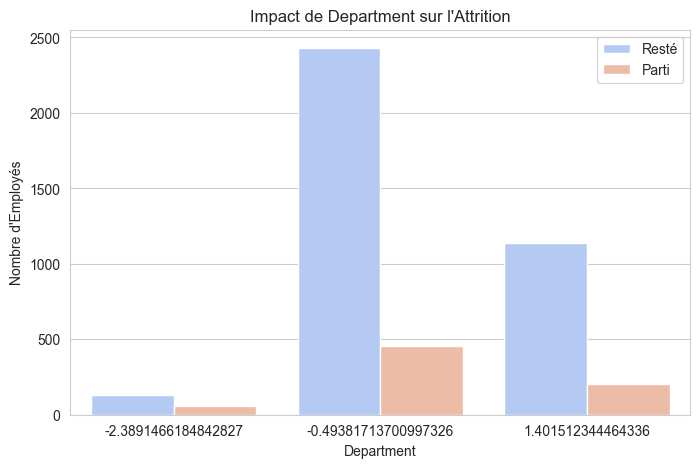

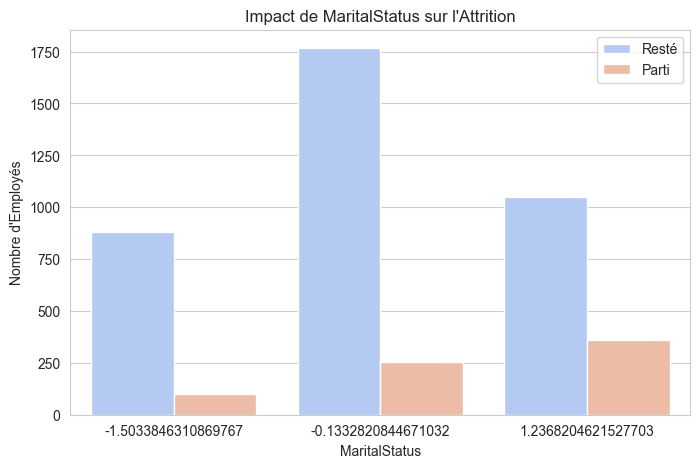

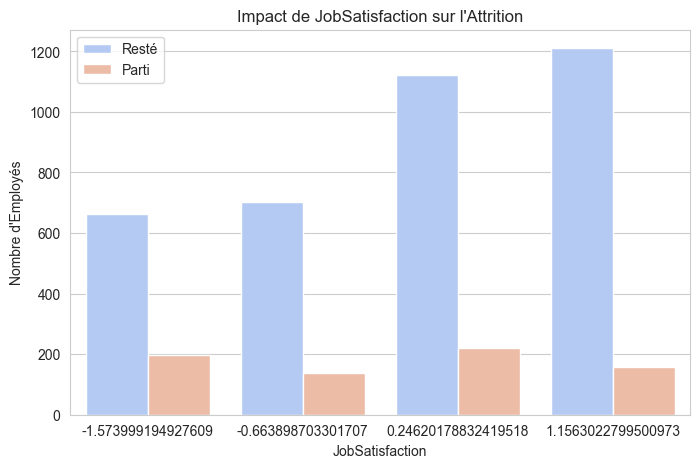

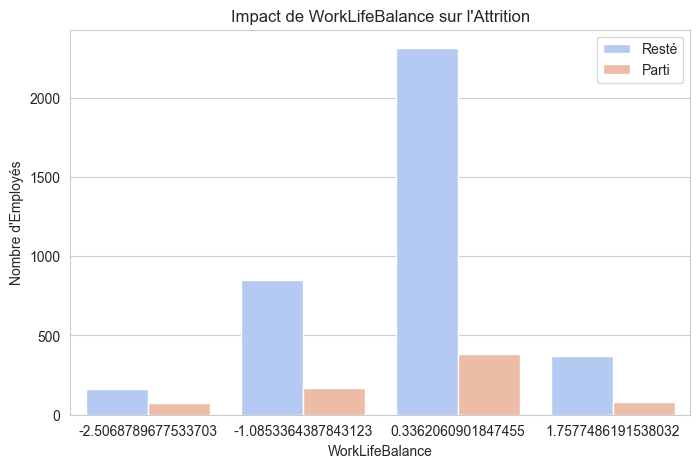

🔍 Test ANOVA : Comparaison des Moyennes entre Restants et Partants

📌 Age : p-value = 0.00000
➡️ Cette variable a un effet significatif sur l'attrition !

📌 MonthlyIncome : p-value = 0.03843
➡️ Cette variable a un effet significatif sur l'attrition !

📌 YearsAtCompany : p-value = 0.00000
➡️ Cette variable a un effet significatif sur l'attrition !

📌 MeanWorkingHours : p-value = 0.00000
➡️ Cette variable a un effet significatif sur l'attrition !

🔍 Test Khi-2 : Dépendance des Variables Catégorielles avec Attrition

📌 BusinessTravel : p-value = 0.00000
➡️ Cette variable est corrélée avec l'attrition !

📌 Department : p-value = 0.00000
➡️ Cette variable est corrélée avec l'attrition !

📌 MaritalStatus : p-value = 0.00000
➡️ Cette variable est corrélée avec l'attrition !

📌 JobSatisfaction : p-value = 0.00000
➡️ Cette variable est corrélée avec l'attrition !

📌 WorkLifeBalance : p-value = 0.00000
➡️ Cette variable est corrélée avec l'attrition !



In [4]:
from scipy.stats import f_oneway, chi2_contingency

# Configurer les paramètres des graphiques
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Vérification de la taille et aperçu des données
print(f"📊 Taille du dataset après prétraitement : {df_merged.shape}")
display(df_merged.head())

# 📌 Fonction : Visualiser les distributions des variables numériques
def plot_numeric_distributions(df, exclude=None, num_cols=8):
    exclude = exclude or []
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in exclude]
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols[:num_cols]):
        plt.subplot(3, 3, i+1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Distribution de {col}")
    plt.tight_layout()
    plt.show()

# 📌 Fonction : Matrice de corrélation améliorée
def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("🔍 Matrice de Corrélation Améliorée")
    plt.show()

# 📌 Fonction : Répartition de la variable cible
def plot_attrition_distribution(df):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df["Attrition"], palette="Set1")
    plt.title("Répartition de l'Attrition (Départs)")
    plt.xticks(ticks=[0, 1], labels=["Resté", "Parti"])
    plt.show()
    attrition_rate = df["Attrition"].mean() * 100
    print(f"📊 Taux d'attrition global : {attrition_rate:.2f}%")

# 📌 Fonction : Étudier l'effet des variables numériques
def plot_numeric_vs_attrition(df, numeric_cols):
    for col in numeric_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x="Attrition", y=col, data=df, palette="Set2")
        plt.title(f"Impact de {col} sur l'Attrition")
        plt.xticks(ticks=[0, 1], labels=["Resté", "Parti"])
        plt.show()

# 📌 Fonction : Étudier l'effet des variables catégorielles
def plot_categorical_vs_attrition(df, categorical_cols):
    for col in categorical_cols:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=col, hue="Attrition", data=df, palette="coolwarm")
        plt.title(f"Impact de {col} sur l'Attrition")
        plt.xlabel(f"{col}")
        plt.ylabel("Nombre d'Employés")
        plt.legend(["Resté", "Parti"])
        plt.show()

# 📌 Fonction : ANOVA (Analyse de Variance)
def anova_test(df, numeric_cols):
    print("🔍 Test ANOVA : Comparaison des Moyennes entre Restants et Partants\n")
    for col in numeric_cols:
        group_0 = df[df["Attrition"] == 0][col]
        group_1 = df[df["Attrition"] == 1][col]
        stat, p_value = f_oneway(group_0, group_1)
        print(f"📌 {col} : p-value = {p_value:.5f}")
        if p_value < 0.05:
            print("➡️ Cette variable a un effet significatif sur l'attrition !\n")
        else:
            print("⏳ Pas d'effet significatif.\n")

# 📌 Fonction : Test Khi-2 pour les variables catégorielles
def chi2_test(df, categorical_cols):
    print("🔍 Test Khi-2 : Dépendance des Variables Catégorielles avec Attrition\n")
    for col in categorical_cols:
        contingency_table = pd.crosstab(df[col], df["Attrition"])
        stat, p_value, _, _ = chi2_contingency(contingency_table)
        print(f"📌 {col} : p-value = {p_value:.5f}")
        if p_value < 0.05:
            print("➡️ Cette variable est corrélée avec l'attrition !\n")
        else:
            print("⏳ Pas d'effet significatif.\n")


# Distribution des variables numériques
plot_numeric_distributions(df_merged, exclude=["Attrition"])

# Matrice de corrélation
plot_correlation_matrix(df_merged)

# Répartition de la cible
plot_attrition_distribution(df_merged)

# Étudier l'impact des variables numériques
numeric_cols = ["Age", "MonthlyIncome", "YearsAtCompany", "MeanWorkingHours"]
plot_numeric_vs_attrition(df_merged, numeric_cols)

# Étudier l'impact des variables catégorielles
categorical_cols = ["BusinessTravel", "Department", "MaritalStatus", "JobSatisfaction", "WorkLifeBalance"]
plot_categorical_vs_attrition(df_merged, categorical_cols)

# Test ANOVA pour les variables numériques
anova_test(df_merged, numeric_cols)

# Test Khi-2 pour les variables catégorielles
chi2_test(df_merged, categorical_cols)



# 3. Modélisation Prédictive

📊 Taille de X_train : (3528, 25)
📊 Taille de X_test : (882, 25)

🚀 Entraînement du modèle : Logistic Regression
Accuracy : 0.8503
Precision : 0.6190
Recall : 0.1831
F1 Score : 0.2826
ROC-AUC : 0.7823

🚀 Entraînement du modèle : Random Forest
Accuracy : 0.9966
Precision : 1.0000
Recall : 0.9789
F1 Score : 0.9893
ROC-AUC : 0.9970

🚀 Entraînement du modèle : XGBoost
Accuracy : 0.9966
Precision : 1.0000
Recall : 0.9789
F1 Score : 0.9893
ROC-AUC : 0.9888

📊 Résultats des modèles :


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression,0.850340,0.619048,0.183099,0.282609,0.782290
Random Forest,0.996599,1.000000,0.978873,0.989324,0.996974
XGBoost,0.996599,1.000000,0.978873,0.989324,0.988809


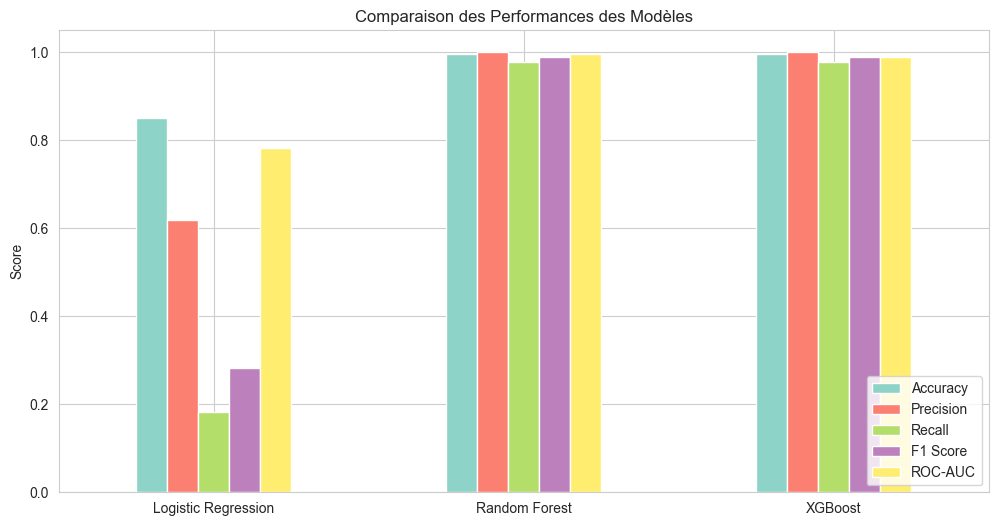

📊 Meilleur modèle : Random Forest


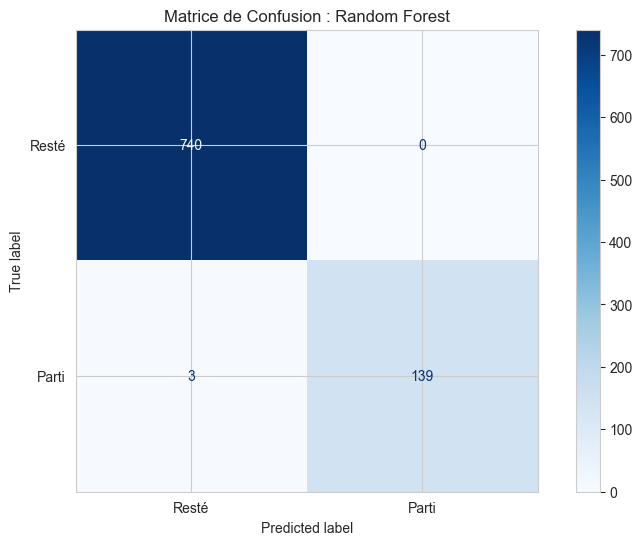

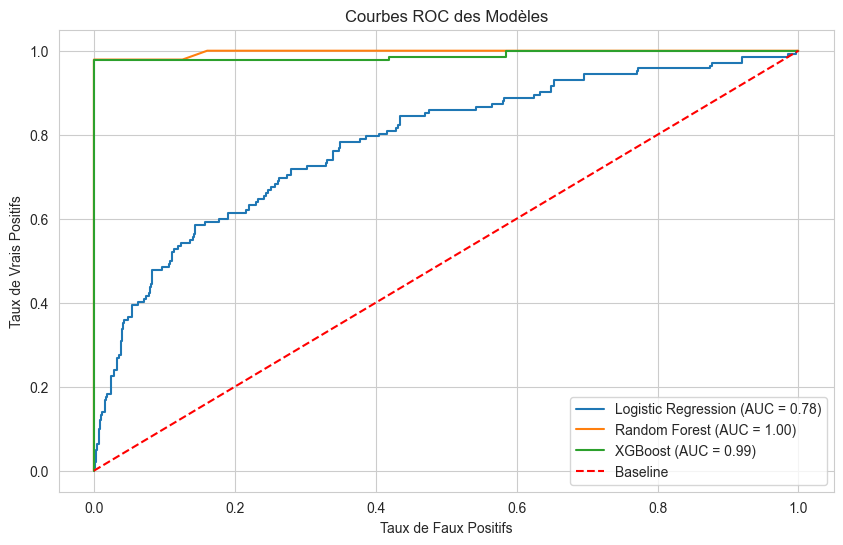

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 📌 Séparer les features (X) et la cible (y)
X = df_merged.drop(columns=["Attrition", "EmployeeID"])  # Exclure la cible et les identifiants
y = df_merged["Attrition"]

# 📌 Diviser en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 📌 Standardisation des données numériques
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"📊 Taille de X_train : {X_train.shape}")
print(f"📊 Taille de X_test : {X_test.shape}")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 📌 Initialisation des modèles
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
}

# 📌 Stocker les performances
model_results = {}

for model_name, model in models.items():
    print(f"\n🚀 Entraînement du modèle : {model_name}")
    model.fit(X_train, y_train)  # Entraînement
    y_pred = model.predict(X_test)  # Prédictions
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilités pour ROC-AUC
    
    # 📊 Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC-AUC : {roc_auc:.4f}")
    
    # 📊 Stocker les résultats
    model_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc,
    }

# 📊 Résumé des performances
results_df = pd.DataFrame(model_results).T
print("\n📊 Résultats des modèles :")
display(results_df)

# 📊 Comparaison graphique des métriques
results_df.plot(kind="bar", figsize=(12, 6), cmap="Set3")
plt.title("Comparaison des Performances des Modèles")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# 📌 Identifier le meilleur modèle (basé sur F1-score)
best_model_name = results_df["F1 Score"].idxmax()
best_model = models[best_model_name]

# 📌 Générer la matrice de confusion
from sklearn.metrics import ConfusionMatrixDisplay

print(f"📊 Meilleur modèle : {best_model_name}")
y_pred_best = best_model.predict(X_test)

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=["Resté", "Parti"], cmap="Blues")
plt.title(f"Matrice de Confusion : {best_model_name}")
plt.show()

from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Diagonale de référence
plt.plot([0, 1], [0, 1], 'r--', label="Baseline")
plt.title("Courbes ROC des Modèles")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.legend(loc="lower right")
plt.show()


# 4. Optimisation et Amélioration


🚀 Optimisation en cours : Random Forest (GridSearch)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ Meilleurs paramètres pour Random Forest (GridSearch) : {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}

🚀 Optimisation en cours : XGBoost (GridSearch)...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
✅ Meilleurs paramètres pour XGBoost (GridSearch) : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}

🚀 Optimisation en cours : Random Forest (RandomizedSearch)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Meilleurs paramètres pour Random Forest (RandomizedSearch) : {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}

🚀 Évaluation du modèle : Random Forest (GridSearch)

🚀 Évaluation du modèle : XGBoost (GridSearch)

🚀 Évaluation du modèle : Random Forest (RandomizedSearch)

📊 Résultats des m

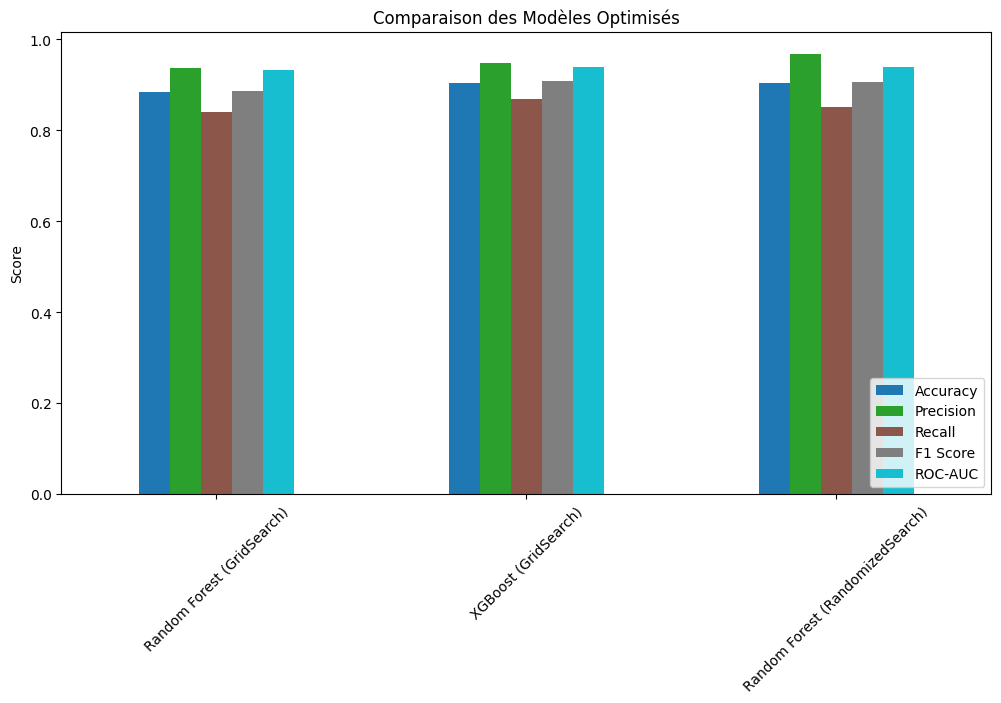

In [27]:
# 📌 Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin

# 🚀 **Solution : Wrapper Scikit-learn pour XGBoost**
class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y, **kwargs):
        """ Entraînement du modèle """
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        """ Prédiction des classes """
        return self.model.predict(X)

    def predict_proba(self, X):
        """ Prédiction des probabilités """
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        """ Retourne les hyperparamètres du modèle """
        return self.model.get_params(deep)

    def set_params(self, **params):
        """ Met à jour les hyperparamètres du modèle """
        self.model.set_params(**params)
        return self

# 📌 Vérification des données
try:
    X_train, y_train
except NameError:
    raise ValueError("X_train et y_train ne sont pas définis. Exécutez d'abord la préparation des données.")

# 📌 Initialisation des modèles
rf = RandomForestClassifier(random_state=42)
xgb = SklearnXGBClassifier(eval_metric="logloss", tree_method="hist", random_state=42)

# 📌 Définition des grilles d'hyperparamètres
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

param_grid_xgb = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

param_dist_rf = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

# 📌 Définition des recherches d'hyperparamètres
searchers = {
    "Random Forest (GridSearch)": GridSearchCV(
        estimator=rf, param_grid=param_grid_rf, scoring="f1", cv=5, verbose=1, n_jobs=-1
    ),
    "XGBoost (GridSearch)": GridSearchCV(
        estimator=xgb, param_grid=param_grid_xgb, scoring="f1", cv=5, verbose=1, n_jobs=-1
    ),
    "Random Forest (RandomizedSearch)": RandomizedSearchCV(
        estimator=rf, param_distributions=param_dist_rf, n_iter=50, scoring="f1",
        cv=5, verbose=1, random_state=42, n_jobs=-1
    ),
}

# 📌 Optimisation des modèles
best_models = {}
for name, search in searchers.items():
    print(f"\n🚀 Optimisation en cours : {name}...")
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"✅ Meilleurs paramètres pour {name} : {search.best_params_}")

# 📌 Évaluation des modèles
results = {}
for name, model in best_models.items():
    print(f"\n🚀 Évaluation du modèle : {name}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
    }

# 📌 Affichage des résultats
df_results = pd.DataFrame(results).T
print("\n📊 Résultats des modèles optimisés :")
print(df_results)

# 📌 Visualisation des performances
df_results.plot(kind="bar", figsize=(12, 6), cmap="tab10")
plt.title("Comparaison des Modèles Optimisés")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


# 5️. Interprétation & Recommandations

In [33]:
# 📌 Sélection du meilleur modèle (basé sur le F1-score)
best_model_name = df_results["F1 Score"].idxmax()  
best_model = best_models[best_model_name]

print(f"\n✅ Le meilleur modèle sélectionné est : {best_model_name}")



✅ Le meilleur modèle sélectionné est : XGBoost (GridSearch)


In [ ]:
# 📌 Récupérer les noms des colonnes avant transformation
feature_names = df_merged.drop(columns=["Attrition", "EmployeeID"]).columns

# 📌 Affichage des variables importantes
plot_feature_importances(best_model, feature_names, best_model_name)

# 📌 Fonction pour afficher les variables les plus importantes
def plot_feature_importances(model, feature_names, model_name, top_n=10):
    """Affichage des variables les plus importantes du modèle"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]  # Trier par importance descendante
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")
    plt.title(f"🔍 Top {top_n} Variables Impactant l'Attrition - {model_name}")
    plt.xlabel("Importance Relative")
    plt.ylabel("Variables")
    plt.show()

# 📌 Affichage des variables importantes
feature_names = X.columns  # Stocker les noms des variables avant transformation
plot_feature_importances(best_model, feature_names, best_model_name)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [32]:
def plot_numeric_vs_attrition(df, numeric_cols):
    for col in numeric_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x="Attrition", y=col, data=df, palette="Set2")
        plt.title(f"Impact de {col} sur l'Attrition")
        plt.xticks(ticks=[0, 1], labels=["Resté", "Parti"])
        plt.show()

numeric_cols = ["Age", "MonthlyIncome", "YearsAtCompany", "WorkLifeBalance"]
plot_numeric_vs_attrition(df_merged, numeric_cols)


NameError: name 'df_merged' is not defined

# Zone de test des libs

In [ ]:
import numpy as np
import scipy
import sklearn

print(f"Numpy version: {np.__version__}")
print(f"Scipy version: {scipy.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")


In [1]:
import sklearn
import xgboost

print(f"Scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")


Scikit-learn version: 1.6.1
XGBoost version: 2.1.3


Régler les problèmes de compatibilités de Scikit-learn 

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# 📌 Génération d'un jeu de données factice (à remplacer par tes données réelles)
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# 📌 Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


class SklearnCompatibleXGB(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.params = kwargs
        self.model = XGBClassifier(eval_metric="logloss", tree_method="hist", random_state=42, **kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        self.params.update(params)
        self.model = XGBClassifier(eval_metric="logloss", tree_method="hist", random_state=42, **self.params)
        return self


In [5]:
from sklearn.model_selection import GridSearchCV

# Définition de la grille de paramètres XGBoost
param_grid_xgb = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

# Instancier le wrapper
xgb_wrapper = SklearnCompatibleXGB()

# GridSearchCV avec le wrapper
grid_search_xgb = GridSearchCV(
    estimator=xgb_wrapper,
    param_grid=param_grid_xgb,
    scoring="f1",
    cv=5,
    verbose=2,
    n_jobs=-1,
)

# Entraînement
print("🚀 Optimisation de XGBoost avec GridSearchCV...")
grid_search_xgb.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres
print(f"✅ Meilleurs paramètres XGBoost (GridSearch) : {grid_search_xgb.best_params_}")


🚀 Optimisation de XGBoost avec GridSearchCV...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
✅ Meilleurs paramètres XGBoost (GridSearch) : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}


In [6]:
# Meilleur modèle trouvé par GridSearchCV
best_xgb = grid_search_xgb.best_estimator_

# Prédictions sur les données de test
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Évaluer les performances
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n📊 **Performance du Meilleur XGBoost Optimisé** :")
print(f"✅ Accuracy : {accuracy:.4f}")
print(f"✅ Precision : {precision:.4f}")
print(f"✅ Recall : {recall:.4f}")
print(f"✅ F1 Score : {f1:.4f}")
print(f"✅ ROC-AUC : {roc_auc:.4f}")



📊 **Performance du Meilleur XGBoost Optimisé** :
✅ Accuracy : 0.9050
✅ Precision : 0.9490
✅ Recall : 0.8692
✅ F1 Score : 0.9073
✅ ROC-AUC : 0.9390
